In [1]:
import imp
import time
import argparse
import numpy as np
import torch
torch.set_printoptions(threshold=10000)
from torch_geometric.datasets import Planetoid,Reddit2,Flickr
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
# from torch_geometric.loader import DataLoader
from help_funcs import prune_unrelated_edge,prune_unrelated_edge_isolated, clu_prune_unrelated_edge
import scipy.sparse as sp
from torch_geometric.utils import subgraph
# Training settings
parser = argparse.ArgumentParser()
parser.add_argument('--debug', action='store_true',
        default=True, help='debug mode')
parser.add_argument('--no-cuda', action='store_true', default=False,
                    help='Disables CUDA training.')
parser.add_argument('--seed', type=int, default=12, help='Random seed.')
parser.add_argument('--model', type=str, default='GCN', help='model',
                    choices=['GCN','GAT','GraphSage','GIN'])
parser.add_argument('--dataset', type=str, default='Flickr', 
                    help='Dataset',
                    choices=['Cora','Pubmed','Flickr','ogbn-arxiv','Citeseer','Reddit2'])
parser.add_argument('--train_lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--weight_decay', type=float, default=5e-4,
                    help='Weight decay (L2 loss on parameters).')
parser.add_argument('--hidden', type=int, default=128,
                    help='Number of hidden units.')
parser.add_argument('--thrd', type=float, default=0.5)
parser.add_argument('--target_class', type=int, default=6)
parser.add_argument('--k', type=int, default=100)
parser.add_argument('--dropout', type=float, default=0.5,
                    help='Dropout rate (1 - keep probability).')
parser.add_argument('--epochs', type=int,  default=1000, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--rec_epochs', type=int,  default=30, help='Number of epochs to train benign and backdoor model.')
parser.add_argument('--trojan_epochs', type=int,  default=400, help='Number of epochs to train trigger generator.')
parser.add_argument('--inner', type=int,  default=1, help='Number of inner')
# backdoor setting
parser.add_argument('--lr', type=float, default=0.01,
                    help='Initial learning rate.')
parser.add_argument('--trigger_size', type=int, default=3,
                    help='tirgger_size')
parser.add_argument('--use_vs_number', action='store_true', default=True,
                    help="if use detailed number to decide Vs")
parser.add_argument('--vs_ratio', type=float, default=0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--range', type=float, default=1.0,
                    help="ratio of poisoning nodes relative to the full graph")
parser.add_argument('--vs_number', type=int, default=160,
                    help="number of poisoning nodes relative to the full graph")
# defense setting
parser.add_argument('--defense_mode', type=str, default="none",
                    choices=['prune', 'isolate', 'none','reconstruct'],
                    help="Mode of defense")
parser.add_argument('--prune_thr', type=float, default=0.8,
                    help="Threshold of prunning edges")
parser.add_argument('--target_loss_weight', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_target', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_ood', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--weight_targetclass', type=float, default=1,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--outter_size', type=int, default=4096,
                    help="Weight of optimize outter trigger generator")
parser.add_argument('--homo_loss_weight', type=float, default=100,
                    help="Weight of optimize similarity loss")
parser.add_argument('--homo_boost_thrd', type=float, default=0.8,
                    help="Threshold of increase similarity")
# attack setting
parser.add_argument('--dis_weight', type=float, default=1,
                    help="Weight of cluster distance")
parser.add_argument('--selection_method', type=str, default='none',
                    choices=['loss','conf','cluster','none','cluster_degree'],
                    help='Method to select idx_attach for training trojan model (none means randomly select)')
parser.add_argument('--test_model', type=str, default='GCN',
                    choices=['GCN','GAT','GraphSage','GIN'],
                    help='Model used to attack')
parser.add_argument('--evaluate_mode', type=str, default='1by1',
                    choices=['overall','1by1'],
                    help='Model used to attack')
# GPU setting
parser.add_argument('--device_id', type=int, default=2,
                    help="Threshold of prunning edges")
# args = parser.parse_args()
args = parser.parse_known_args()[0]
args.cuda =  not args.no_cuda and torch.cuda.is_available()
device = torch.device(('cuda:{}' if torch.cuda.is_available() else 'cpu').format(args.device_id))

np.random.seed(args.seed)
torch.manual_seed(args.seed)
torch.cuda.manual_seed(args.seed)
print(args)

/tmp/ipykernel_118544/3653330298.py:1: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Namespace(cuda=True, dataset='Flickr', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=6, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=160, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [2]:
from torch_geometric.utils import to_undirected
import torch_geometric.transforms as T
transform = T.Compose([T.NormalizeFeatures()])

if(args.dataset == 'Cora' or args.dataset == 'Citeseer' or args.dataset == 'Pubmed'):
    dataset = Planetoid(root='./data/', \
                        name=args.dataset,\
                        transform=transform)
elif(args.dataset == 'Flickr'):
    dataset = Flickr(root='./data/Flickr/', \
                    transform=transform)
elif(args.dataset == 'Reddit2'):
    dataset = Reddit2(root='./data/Reddit2/', \
                    transform=transform)
elif(args.dataset == 'ogbn-arxiv'):
    from ogb.nodeproppred import PygNodePropPredDataset
    # Download and process data at './dataset/ogbg_molhiv/'
    dataset = PygNodePropPredDataset(name = 'ogbn-arxiv', root='./data/')
    split_idx = dataset.get_idx_split() 

data = dataset[0].to(device)

if(args.dataset == 'ogbn-arxiv'):
    nNode = data.x.shape[0]
    setattr(data,'train_mask',torch.zeros(nNode, dtype=torch.bool).to(device))
    # dataset[0].train_mask = torch.zeros(nEdge, dtype=torch.bool).to(device)
    data.val_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.test_mask = torch.zeros(nNode, dtype=torch.bool).to(device)
    data.y = data.y.squeeze(1)
    
if(args.dataset == 'Reddit2'):
    num_nodes_to_sample = 20000  # Adjust this based on your needs

    # Randomly select a subset of nodes
    sampled_nodes = torch.randint(data.num_nodes, (num_nodes_to_sample,), device=device)

    # Perform subgraph sampling
    edge,_ = subgraph(sampled_nodes, data.edge_index)
    data.edge_index = edge

In [3]:
from utils import get_split
data, idx_train, idx_val, idx_clean_test, idx_atk = get_split(args,data,device)

from torch_geometric.utils import to_undirected
from utils import subgraph
data.edge_index = to_undirected(data.edge_index)
train_edge_index,_, edge_mask = subgraph(torch.bitwise_not(data.test_mask),data.edge_index,relabel_nodes=False)
mask_edge_index = data.edge_index[:,torch.bitwise_not(edge_mask)]

In [4]:
from sklearn_extra import cluster
from models.backdoor import Backdoor
from models.construct import model_construct
import heuristic_selection as hs
from torch.distributions.bernoulli import Bernoulli

# select poisoned target node #

# filter out the unlabeled nodes except from training nodes and testing nodes, nonzero() is to get index, flatten is to get 1-d tensor
unlabeled_idx = (torch.bitwise_not(data.test_mask)&torch.bitwise_not(data.train_mask)).nonzero().flatten()
if(args.use_vs_number):
    size = args.vs_number
else:
    size = int((len(data.test_mask)-data.test_mask.sum())*args.vs_ratio)
# print("#Attach Nodes:{}".format(size))
assert size>0, 'The number of selected trigger nodes must be larger than 0!'
# here is randomly select poison nodes from unlabeled nodes
if(args.selection_method == 'none'):
    idx_attach = hs.obtain_attach_nodes(args,unlabeled_idx,size)
elif(args.selection_method == 'cluster'):
    idx_attach = hs.cluster_distance_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
elif(args.selection_method == 'cluster_degree'):
    if(args.dataset == 'Pubmed'):
        idx_attach = hs.cluster_degree_selection_seperate_fixed(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    else:
        idx_attach = hs.cluster_degree_selection(args,data,idx_train,idx_val,idx_clean_test,unlabeled_idx,train_edge_index,size,device)
    idx_attach = torch.LongTensor(idx_attach).to(device)
# print("idx_attach: {}".format(idx_attach))
unlabeled_idx = torch.tensor(list(set(unlabeled_idx.cpu().numpy()) - set(idx_attach.cpu().numpy()))).to(device)
print('number of benign training nodes', len(idx_train))
print('number of poisoned target nodes', len(idx_attach))

# Cora
# idx_attach = torch.tensor([1672, 2399, 1785, 2020, 2013, 1652,  208, 1220, 2128,  446])
# Flicker
idx_attach = torch.tensor([29275,  8277, 58360, 41079, 86956, 52657,  8025, 43945, 27742, 34360,
        75703, 64789, 73423, 32280, 11374, 47231, 38650,  3650, 72570, 83872,
        75588, 23969, 40514, 83189, 27184, 75600, 85582,  2740,  8943, 71493,
        16605, 85703,  7009, 46944, 56822, 23292, 12834, 55088, 51592,  7573,
        67003, 88385, 22669, 10438, 16924, 52101, 27347, 36452,  1118, 22296,
         7257, 80969, 13553, 32145, 42512, 26391, 84506, 53286, 37153, 77240,
         4639, 17383, 63469, 83400, 51652, 67247, 38059, 22925, 40246, 50018,
        79544,  7984, 61602, 53426, 27243, 17493, 67171, 79262, 65139, 87487,
        43132, 29847, 68593, 24899, 21589, 29457, 79249, 80782, 72046, 47508,
        21765, 15693, 84429, 36219, 46422, 28997, 64226,  1813, 57285, 49813,
        58672, 10026, 27640, 43213, 74386, 70837,  7673, 55467, 83166, 11597,
        37742, 50621,  9373, 88820, 37517, 74207, 56241,  3886, 89213, 13859,
        24500, 55067, 39695, 64831, 13788, 54202, 69679, 10341, 77859,  8224,
        77819, 86867, 80194, 32467, 69911, 38369, 17766, 88900, 62128, 33190,
        51926, 15266, 84837, 56045, 87807, 86648, 61288, 26109, 48380, 61494,
         5076, 10920, 80378, 29961, 65730, 37906, 20524, 22206, 56017, 48770])

idx_attach = idx_attach.to(device)

number of benign training nodes 17850
number of poisoned target nodes 160


In [5]:
## trigger generator ##
model = Backdoor(args,device)
model.fit(data.x, train_edge_index, None, data.y, idx_train,idx_attach, unlabeled_idx, True)

0

In [6]:
test_model = 'GCN'
total_overall_asr = 0
total_overall_ca = 0
args.test_model = test_model
rs = np.random.RandomState(args.seed)
seeds = rs.randint(1000,size=1)
overall_asr = 0
overall_ca = 0

In [7]:
# load poisoned graph #
# poison_x = torch.load('poison_x.pt')
# poison_edge_index = torch.load('poison_edge_index.pt')
# poison_edge_weights = torch.load('poison_edge_weights.pt')
# poison_labels = torch.load('poison_labels.pt')
poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_x_flicker.pt')
poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_index_flicker.pt')
poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_edge_weights_flicker.pt')
poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run/poison_labels_flicker.pt')
# poison_x = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_x.pt')
# poison_edge_index = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_index.pt')
# poison_edge_weights = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_edge_weights.pt')
# poison_labels = torch.load('/home/zbz5349/defense_backdoor/DPGBA/kdd-backdooor/run_arxiv/poison_labels.pt')

In [8]:
print(args)

mask = data.y[idx_attach] != args.target_class
mask = mask.to(device)

## only attack those has groud truth labels != target_class ##
idx_attach = idx_attach[(data.y[idx_attach] != args.target_class).nonzero().flatten()]

bkd_tn_nodes = torch.cat([idx_train,idx_attach]).to(device)
# test_model = model_construct(args,args.test_model,data,device).to(device) 
known_nodes = torch.cat([idx_train,idx_attach]).to(device)
predictions = []
# edge weight for clean edge_index, may use later #
edge_weight = torch.ones([data.edge_index.shape[1]],device=device,dtype=torch.float)


Namespace(cuda=True, dataset='Flickr', debug=True, defense_mode='none', device_id=2, dis_weight=1, dropout=0.5, epochs=1000, evaluate_mode='1by1', hidden=128, homo_boost_thrd=0.8, homo_loss_weight=100, inner=1, k=100, lr=0.01, model='GCN', no_cuda=False, outter_size=4096, prune_thr=0.8, range=1.0, rec_epochs=30, seed=12, selection_method='none', target_class=6, target_loss_weight=1, test_model='GCN', thrd=0.5, train_lr=0.01, trigger_size=3, trojan_epochs=400, use_vs_number=True, vs_number=160, vs_ratio=0, weight_decay=0.0005, weight_ood=1, weight_target=1, weight_targetclass=1)


In [9]:
mask.sum()

tensor(93, device='cuda:2')

In [10]:
print(data.y[idx_attach])
# idx_attach is selected target node #
print(poison_labels[idx_attach])

tensor([3, 4, 1, 2, 1, 1, 4, 2, 5, 5, 4, 4, 1, 3, 5, 1, 3, 2, 5, 2, 2, 2, 1, 2,
        4, 4, 0, 1, 1, 3, 4, 4, 3, 2, 1, 0, 4, 4, 5, 2, 2, 4, 4, 2, 4, 4, 4, 2,
        4, 3, 4, 4, 2, 2, 1, 5, 5, 1, 3, 1, 3, 5, 3, 2, 4, 0, 2, 0, 4, 4, 2, 4,
        0, 3, 4, 1, 4, 4, 4, 2, 1, 4, 4, 0, 2, 4, 4, 1, 2, 4, 1, 1, 2],
       device='cuda:2')
tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:2')


In [11]:
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False)
test_model.eval()
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)
output_clean, x = test_model(poison_x,poison_edge_index,poison_edge_weights)
ori_predict = torch.exp(output_clean[known_nodes])
print("accuracy on poisoned target nodes: {:.4f}".format(clean_acc))

accuracy on poisoned target nodes: 0.7634


In [12]:
output_clean[idx_attach].argmax(dim=1)

tensor([4, 6, 6, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6,
        6, 4, 6, 6, 6, 6, 4, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6,
        6, 6, 4, 6, 6, 6, 6, 4, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 4, 6, 6, 4,
        6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:2')

In [13]:
# test backdoored model for comparison #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.8622
Flip ASR: 0.8057/4971 nodes
CA: 0.4559


In [14]:
# edge drop #
def sample_noise_all(edge_index, edge_weight,device):
    noisy_edge_index = edge_index.clone().detach()
    if(edge_weight == None):
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    else:
        noisy_edge_weight = edge_weight.clone().detach()
    # # rand_noise_data = copy.deepcopy(data)
    # rand_noise_data.edge_weight = torch.ones([rand_noise_data.edge_index.shape[1],]).to(device)
    m = Bernoulli(torch.tensor([0.8]).to(device))
    mask = m.sample(noisy_edge_weight.shape).squeeze(-1).int()
    # print('mask',mask)
    rand_inputs = torch.randint_like(noisy_edge_weight, low=0, high=2).squeeze().int().to(device)
    # print(rand_noise_data.edge_weight.shape,mask.shape)
    noisy_edge_weight = noisy_edge_weight * mask #+ rand_inputs * (1-mask)
        
    if(noisy_edge_weight!=None):
        noisy_edge_index = noisy_edge_index[:,noisy_edge_weight.nonzero().flatten().long()]
        noisy_edge_weight = torch.ones([noisy_edge_index.shape[1],]).to(device)
    return noisy_edge_index, noisy_edge_weight

In [15]:
# test robustness #
for i in range(100):
            test_model.eval()
            noisy_poison_edge_index, noisy_poison_edge_weights = sample_noise_all(poison_edge_index, poison_edge_weights, device)
            output, x = test_model(poison_x,noisy_poison_edge_index,noisy_poison_edge_weights)
            train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
            train_clean_rate = (output.argmax(dim=1)[idx_train]==data.y[idx_train]).float().mean()
            predictions.append(torch.exp(output[known_nodes]))

In [16]:
# torch.argmax(predictions[8][23868])

In [17]:
epsilon = 1e-8
deviations = []
for sub_pred in predictions:
    sub_pred += epsilon
    deviation = F.kl_div(sub_pred.log(), ori_predict, reduce=False)
    deviations.append(deviation)

summed_deviations = torch.zeros_like(deviations[0]).to(deviations[0].device)
for deviation in deviations:
    ##### summed deviations for each node #####
    summed_deviations += deviation


##### get the index for nodes with less robustness #####
    
##### args.vs_number is unknown #####
index_of_less_robust = torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[1][:mask.sum()]
print('index_of_less_robust',index_of_less_robust)

##### count how many poisoned target nodes are selected in less robustness nodes #####
count = 0
dd = []
for idx in index_of_less_robust:
    if idx >= len(known_nodes)-args.vs_number:
        count += 1
        dd.append(idx)
print('count',count)

index_of_less_robust tensor([16367, 15486,  7497, 13566, 14550, 12943,  1950,  6304, 11228, 13606,
         5441,  6080, 17697,  3804, 17270,  5722, 16152, 14842, 16183,  9578,
        11631,  2862,  4182, 10472, 14627, 11173,  1901,  2772,   450,   327,
        14048,  2139, 15405,  7594,  5387, 11561, 16952,  4413,  8037,  6361,
         7548,  8512,  3275,  7882,  5767,  5494,  8212,  1326,  4555, 17030,
         6164,  3359,  5876, 10983, 12161, 15231, 15408, 10452,  8853, 14084,
         4651,  2228, 11243, 16717,  3434,  4711, 11153, 17731,  4794, 11933,
        12502, 14691, 15487,  1794,  8312,  7974, 15208,  9762, 15711, 15427,
        14348, 17577,  8023, 13228, 12377,  7756, 16447,  5962, 16395,  5309,
         4570,  4054, 13256], device='cuda:2')
count 0


/home/zbz5349/anaconda3/envs/spurious/lib/python3.8/site-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='none' instead.
  warnings.warn(warning.format(ret))


In [18]:
torch.sort(torch.mean(summed_deviations,dim=-1),descending=True)[0][:mask.sum()]

tensor([0.7801, 0.6997, 0.6249, 0.5920, 0.5811, 0.5768, 0.5507, 0.5457, 0.5123,
        0.5118, 0.4709, 0.4468, 0.4148, 0.4111, 0.4037, 0.3905, 0.3788, 0.3725,
        0.3637, 0.3633, 0.3545, 0.3534, 0.3459, 0.3379, 0.3281, 0.3182, 0.3058,
        0.3054, 0.3052, 0.3050, 0.2978, 0.2928, 0.2900, 0.2811, 0.2729, 0.2726,
        0.2710, 0.2703, 0.2635, 0.2632, 0.2578, 0.2458, 0.2439, 0.2423, 0.2417,
        0.2384, 0.2381, 0.2356, 0.2349, 0.2347, 0.2330, 0.2244, 0.2210, 0.2207,
        0.2190, 0.2127, 0.2048, 0.2048, 0.2025, 0.2007, 0.2005, 0.1996, 0.1976,
        0.1971, 0.1967, 0.1966, 0.1949, 0.1923, 0.1879, 0.1835, 0.1784, 0.1769,
        0.1738, 0.1721, 0.1720, 0.1707, 0.1699, 0.1694, 0.1644, 0.1632, 0.1621,
        0.1595, 0.1595, 0.1580, 0.1553, 0.1550, 0.1544, 0.1543, 0.1535, 0.1519,
        0.1502, 0.1497, 0.1496], device='cuda:2', grad_fn=<SliceBackward0>)

In [19]:
print(len(ori_predict))
mask.sum()

17943


tensor(93, device='cuda:2')

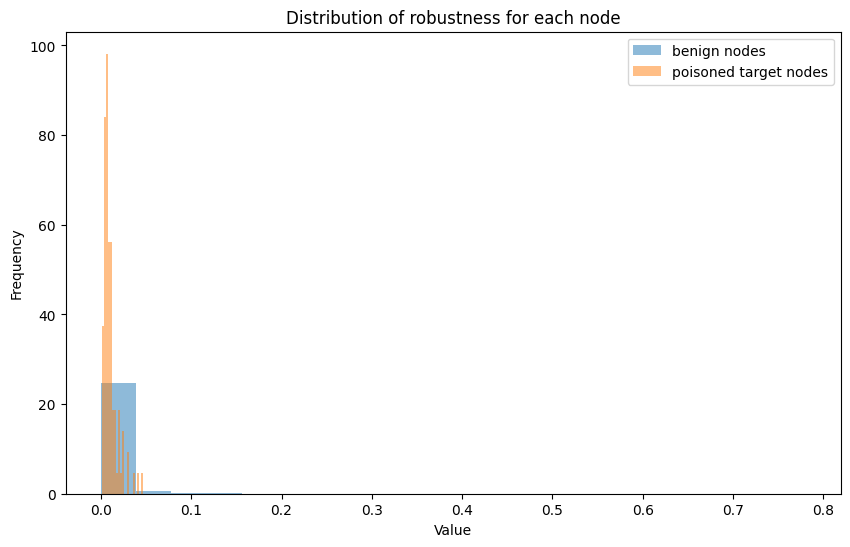

In [20]:


# visualize robustness distribution #
a=torch.mean(summed_deviations,dim=-1)
a_excluding_last_40 = a[:-args.vs_number].detach().cpu()
a_last=a[-mask.sum():].detach().cpu()


a_last_40 = a[-args.vs_number:].detach().cpu()




indices_to_remove = [i for i, node in enumerate(known_nodes[-args.vs_number:]) if data.y[node] == args.target_class]

indices_to_remove = []

a_last_list = list(a_last)

indices_to_check = range(len(known_nodes[-args.vs_number:]))

# indices_to_remove = []

# ##### find those nodes that are already have target class or poisoned failed #####
# for i in indices_to_check:
#     condition1 = data.y[known_nodes[-args.vs_number:][i]] == args.target_class
#     condition2 = output.argmax(dim=1)[idx_attach[i]] != args.target_class
    
#     if condition1 or condition2:
#         indices_to_remove.append(i)

# for index in sorted(indices_to_remove, reverse=True):
#     del a_last_list[index]


a_last_40 = a_last_list
plt.figure(figsize=(10, 6))
# plt.figure(figsize=(40, 24))
##### benign nodes #####
plt.hist(a_excluding_last_40, bins=20, alpha=0.5, label='benign nodes', density=True)
##### poisoned success nodes #####
plt.hist(a_last_40, bins=20, alpha=0.5, label='poisoned target nodes',density=True)
plt.legend(loc='upper right')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Distribution of robustness for each node')
plt.savefig('a.jpg')
plt.show()

In [21]:
output_clean[idx_attach].argmax(dim=1)
output_clean = torch.exp(output_clean)

In [22]:
import torch
from torch_geometric.utils import k_hop_subgraph
epsilon = 1e-8

print(output_clean[idx_attach].argmax(dim=1))


from torch_geometric.utils import k_hop_subgraph
result_clean=[]
for node_id in idx_train[:300]:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        result_clean.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_clean)

tensor([4, 6, 6, 6, 6, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 4, 6, 6, 6, 6, 6, 6, 6,
        6, 4, 6, 6, 6, 6, 4, 6, 4, 4, 6, 6, 6, 4, 6, 6, 6, 4, 4, 6, 6, 6, 6, 6,
        6, 6, 4, 6, 6, 6, 6, 4, 6, 4, 4, 6, 4, 6, 4, 6, 6, 6, 6, 6, 4, 6, 6, 4,
        6, 4, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:2')
[0.0002900681574828923, 0.00030336956842802465, 0.00024448762997053564, 0.00022479999461211264, 0.00030091937514953315, 0.0003697435895446688, 0.00037366259493865073, 0.00025181687669828534, 0.00029530376195907593, 0.00026370055275037885, 0.00022812827955931425, 0.00027006439631804824, 0.00027448046603240073, 0.000318559177685529, 0.00029865867691114545, 0.00021966866916045547, 0.00022697981330566108, 0.0002739120973274112, 0.00019542129302863032, 0.00022959496709518135, 0.000313936616294086, 0.0002925300213973969, 0.0002579380525276065, 1.9375767806195654e-05, 0.0003256521304138005, 0.0003118419263046235, 0.0002887131995521486, 0.0003495333658065647, 0.00

In [23]:
result_trigger = []
for node_id in idx_attach:
    node_id = node_id.item()
    subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
    loop_edges = edge_index[:, edge_index[0] == node_id]
    non_loop_edges = edge_index[:, edge_index[0] != node_id]

    selected_x = poison_x[subset]
    
    for i in range(loop_edges.size(1)):
        # Current loop edge to remove
        current_loop_edge = loop_edges[:, i]

        # Find indices of the current loop edge and its reverse
        forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
        reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

        # Combine masks for forward and reverse edges
        combined_mask = forward_edge_mask | reverse_edge_mask

        # Remove both forward and reverse edges from the graph
        modified_edge_index = edge_index[:, ~combined_mask]

        edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

        output, x = test_model(poison_x, modified_edge_index, edge_weights)
        output = output[node_id]
        output = torch.exp(output)
        output += epsilon
        # print(output)
        # print(output_clean[node_id])
        deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
        if loop_edges[:,i][1]>len(data.x):
            # print(loop_edges[:,i][1])
            result_trigger.append(deviation.mean().item())
            
        # else:
        # print(deviation.mean().item())
            # result_clean.append(deviation.mean().item())

        # result_trigger.append(deviation.mean().item())
        # print(deviation.mean().item())
print(result_trigger)

[0.002604300621896982, 0.0008376060286536813, 0.0005395242478698492, 0.017862003296613693, 0.000548592652194202, 0.016056543216109276, 0.009161253459751606, 0.00193543522618711, 0.0006026647170074284, 0.0009776715887710452, 0.010970981791615486, 0.0006650792784057558, 0.002097836695611477, 0.00015693371824454516, 0.00022382184397429228, 0.0033654775470495224, 0.011203611269593239, 0.0029852103907614946, 0.001998824765905738, 0.00010545339318923652, 0.0020024075638502836, 2.0450779629754834e-05, 0.004042793996632099, 0.011264720931649208, 1.230729503731709e-05, 0.0029042705427855253, 0.00017256397404707968, 0.017986971884965897, 0.001922600087709725, 0.011438864283263683, 0.003780781291425228, 0.010400006547570229, 0.005530261900275946, 7.627266313647851e-05, 0.00012190746929263696, 2.5602324967621826e-05, 0.002440558047965169, 5.531311398954131e-05, 0.0002811806625686586, 0.00014153975644148886, 0.02683764323592186, 0.01042106095701456, 0.00362548790872097, 0.001616119290702045, 0.0025

In [24]:
print(len(result_trigger))
print(min(result_trigger))
print(max(result_trigger))
print(sorted(result_trigger,reverse=True))
print(max(result_clean))
print(sorted(result_clean,reverse=True))

92
1.230729503731709e-05
0.02683764323592186
[0.02683764323592186, 0.022131027653813362, 0.017986971884965897, 0.017862003296613693, 0.017744338139891624, 0.016663942486047745, 0.016056543216109276, 0.014300855807960033, 0.011969410814344883, 0.011438864283263683, 0.011264720931649208, 0.011203611269593239, 0.010970981791615486, 0.01042106095701456, 0.010400006547570229, 0.009161253459751606, 0.008809860795736313, 0.00879768468439579, 0.007376721128821373, 0.006333093624562025, 0.006020645145326853, 0.005837129894644022, 0.005530261900275946, 0.005177440587431192, 0.005158641841262579, 0.004919821862131357, 0.004042793996632099, 0.003780781291425228, 0.00362548790872097, 0.0034865376073867083, 0.0033654775470495224, 0.003238138509914279, 0.0029852103907614946, 0.0029307263903319836, 0.0029042705427855253, 0.002604300621896982, 0.0025543742813169956, 0.002440558047965169, 0.002345102373510599, 0.002097836695611477, 0.0020024075638502836, 0.001998824765905738, 0.00193543522618711, 0.0019

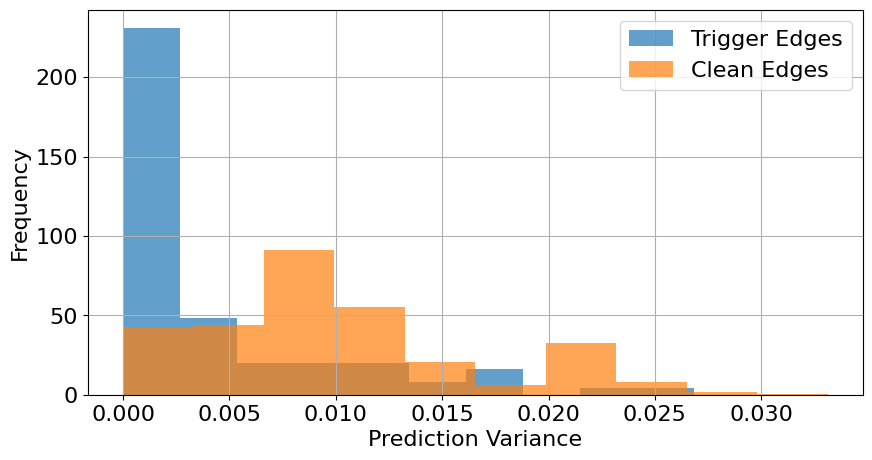

In [25]:
import matplotlib.pyplot as plt

# Ensure you have your data loaded in result_clean and result_trigger
# Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]
# result_trigger = [x for x in result_trigger if x < 0.8 and x>0.2]
# result_clean = [x for x in result_clean if x < 2 and x>0.2]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edge',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edge',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# # plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Prediction Variance')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)

# # Save the plot before displaying it
# plt.savefig('cora.pdf')

# # Display the plot
# plt.show()
plt.figure(figsize=(10, 5))

plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Edges', density=True)
plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Edges', density=True)

plt.xlabel('Prediction Variance',fontsize=16)
plt.ylabel('Frequency',fontsize=16)

# Adjust x and y ticks
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.legend(fontsize=16)
plt.grid(True)

# Add a caption below the figure
# plt.figtext(0.5, -0.05, 'Comparison of prediction variance due to trigger edges drop and clean edges drop.', wrap=True, horizontalalignment='center', fontsize=14)

# Save the plot before displaying it
plt.savefig('cora.pdf')

# Display the plot
plt.show()

In [26]:
# result_clean=[]
# for node_id in idx_train[:10000]:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
#         result_clean.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_clean)


In [27]:
# result_trigger = []
# for node_id in idx_attach:
#     node_id = node_id.item()
#     subset, edge_index, mapping, edge_mask = k_hop_subgraph(node_id, 2, poison_edge_index, relabel_nodes=False)
#     loop_edges = edge_index[:, edge_index[0] == node_id]
#     non_loop_edges = edge_index[:, edge_index[0] != node_id]

#     selected_x = poison_x[subset]
    
#     for i in range(loop_edges.size(1)):
#         # Current loop edge to remove
#         current_loop_edge = loop_edges[:, i]

#         # Find indices of the current loop edge and its reverse
#         forward_edge_mask = (edge_index[0] == current_loop_edge[0]) & (edge_index[1] == current_loop_edge[1])
#         reverse_edge_mask = (edge_index[0] == current_loop_edge[1]) & (edge_index[1] == current_loop_edge[0])

#         # Combine masks for forward and reverse edges
#         combined_mask = forward_edge_mask | reverse_edge_mask

#         # Remove both forward and reverse edges from the graph
#         modified_edge_index = edge_index[:, ~combined_mask]

#         edge_weights = torch.ones(modified_edge_index.size(1), dtype=torch.float, device=device)

#         output, x = test_model(poison_x, modified_edge_index, edge_weights)
#         output = output[node_id]
#         output = torch.exp(output)
#         output += epsilon
#         deviation = F.kl_div(output.log(), output_clean[node_id], reduce=False)
        
#         if loop_edges[:,i][1]>len(data.x):
#             result_trigger.append(deviation.mean().item())
#         else:
#             print(deviation.mean().item())
#             # result_clean.append(deviation.mean().item())

#         result_trigger.append(deviation.mean().item())
#         print(deviation.mean().item())
# print(result_trigger)


In [28]:
# import matplotlib.pyplot as plt

# # Ensure you have your data loaded in result_clean and result_trigger
# # Example: result_clean = [1, 2, 3], result_trigger = [3, 2, 1]

# plt.figure(figsize=(10, 5))

# plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data',density=True)
# # plt.hist(result_trigger, alpha=0.7, bins=10, label='Trigger Data')

# plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data',density=True)
# # plt.hist(result_clean, alpha=0.7, bins=10, label='Clean Data')


# plt.title('Histogram of Clean and Trigger Data')
# plt.xlabel('Value')
# plt.ylabel('Frequency')
# plt.legend()
# plt.grid(True)
# plt.show()

In [29]:
poison_labels[idx_attach] = args.target_class

In [30]:
len(idx_attach)

93

In [31]:
## retrain a model on purified graph ##

# labels for target poisoned node before purified #
print(poison_labels[idx_attach])

# purifying #
# for idx in index_of_less_robust:
#     poison_labels[bkd_tn_nodes[idx]]=data.y[bkd_tn_nodes[idx]]
# # poison_labels[idx_attach] = data.y[idx_attach]

# # labels for target poisoned node after purified #
# print(poison_labels[idx_attach])

# retrain a model #s
test_model = model_construct(args,args.test_model,data,device).to(device) 
test_model.fit(poison_x,poison_edge_index, poison_edge_weights, poison_labels, bkd_tn_nodes, idx_val,train_iters=args.epochs,verbose=False, finetune=True, attach=index_of_less_robust)

## test model on purified graph (poisoned target node) ##
clean_acc = test_model.test(poison_x,poison_edge_index, poison_edge_weights,poison_labels,idx_attach)

print("accuracy on clean test nodes: {:.4f}".format(clean_acc))

tensor([6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6,
        6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6],
       device='cuda:2')
accuracy on clean test nodes: 0.0000


In [32]:
# add a trigger detector #
# assumption: backdoor attack's success is based on trigger pattern #
# 1. outlier, trigger different to each other #
# 2. in distribution, trigger similar to each other #
# # in case, model trained on clean graph learn attack pattern #
induct_edge_index = torch.cat([poison_edge_index,mask_edge_index],dim=1)
induct_edge_weights = torch.cat([poison_edge_weights,torch.ones([mask_edge_index.shape[1]],dtype=torch.float,device=device)])
induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_atk,poison_x,induct_edge_index,induct_edge_weights,device)
# induct_x, induct_edge_index,induct_edge_weights = model.inject_trigger(idx_attach,poison_x,induct_edge_index,induct_edge_weights,device)
induct_x, induct_edge_index,induct_edge_weights = induct_x.clone().detach(), induct_edge_index.clone().detach(),induct_edge_weights.clone().detach()

output, x = test_model(induct_x,induct_edge_index,induct_edge_weights)
train_attach_rate = (output.argmax(dim=1)[idx_atk]==args.target_class).float().mean()
# train_attach_rate = (output.argmax(dim=1)[idx_attach]==args.target_class).float().mean()
print("ASR: {:.4f}".format(train_attach_rate))
asr = train_attach_rate
flip_idx_atk = idx_atk[(data.y[idx_atk] != args.target_class).nonzero().flatten()]
flip_asr = (output.argmax(dim=1)[flip_idx_atk]==args.target_class).float().mean()
print("Flip ASR: {:.4f}/{} nodes".format(flip_asr,flip_idx_atk.shape[0]))
ca = test_model.test(induct_x,induct_edge_index,induct_edge_weights,data.y,idx_clean_test)
print("CA: {:.4f}".format(ca))

ASR: 0.0000
Flip ASR: 0.0000/4971 nodes
CA: 0.4555


In [33]:
output.argmax(dim=1)[idx_atk]

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,

In [34]:
probs=F.softmax(output[index_of_less_robust], dim=1)
probs

tensor([[6.3397e-02, 1.0343e-01, 7.4327e-02, 5.7773e-02, 2.5060e-01, 4.1589e-02,
         4.0889e-01],
        [5.2441e-02, 8.6171e-02, 6.9757e-02, 5.6626e-02, 5.5231e-01, 3.5403e-02,
         1.4729e-01],
        [5.6387e-02, 9.0487e-02, 6.2508e-02, 4.9620e-02, 1.7298e-01, 3.9790e-02,
         5.2823e-01],
        [7.1358e-02, 1.2316e-01, 9.9270e-02, 6.8210e-02, 4.4777e-01, 3.3152e-02,
         1.5709e-01],
        [6.0762e-02, 9.8110e-02, 7.0093e-02, 5.5457e-02, 2.3486e-01, 4.1729e-02,
         4.3899e-01],
        [6.3063e-02, 1.0346e-01, 7.8548e-02, 6.1650e-02, 3.7758e-01, 4.0977e-02,
         2.7473e-01],
        [6.1418e-02, 1.0236e-01, 8.0733e-02, 6.2115e-02, 4.6871e-01, 3.7240e-02,
         1.8742e-01],
        [6.3341e-02, 1.0324e-01, 7.5674e-02, 5.9430e-02, 2.9504e-01, 4.2066e-02,
         3.6121e-01],
        [6.3890e-02, 1.0495e-01, 7.9132e-02, 6.1773e-02, 3.6093e-01, 4.1153e-02,
         2.8817e-01],
        [6.0247e-02, 1.0007e-01, 7.8649e-02, 6.1335e-02, 4.7138e-01, 3.77

In [35]:
probs[range(len(poison_labels[index_of_less_robust])), poison_labels[index_of_less_robust]]

tensor([4.0889e-01, 5.5231e-01, 5.2823e-01, 1.2316e-01, 4.3899e-01, 3.7758e-01,
        1.0236e-01, 5.9430e-02, 2.8817e-01, 1.9061e-01, 4.5726e-01, 1.6651e-01,
        2.2448e-01, 3.8528e-01, 1.2256e-01, 5.0683e-01, 5.7036e-02, 4.0453e-02,
        8.5735e-02, 5.9923e-02, 9.5436e-02, 4.8453e-01, 5.1659e-02, 6.3439e-02,
        1.9613e-01, 6.4748e-02, 1.8339e-01, 2.4240e-01, 4.9247e-01, 2.7756e-05,
        3.3106e-01, 4.8675e-01, 2.8049e-01, 1.1714e-01, 4.2612e-02, 3.7861e-01,
        7.8905e-02, 2.8903e-01, 1.5597e-01, 6.4317e-01, 2.6464e-01, 3.5537e-01,
        3.6487e-01, 7.8572e-02, 3.2458e-01, 6.1615e-02, 1.0272e-01, 5.8045e-02,
        3.1091e-02, 4.3325e-01, 1.0044e-01, 8.4820e-02, 4.8781e-01, 2.5325e-01,
        4.8652e-01, 2.9353e-01, 3.2103e-01, 4.1093e-01, 4.4556e-01, 5.7196e-02,
        5.4557e-01, 9.0065e-01, 7.4504e-02, 8.7740e-02, 5.0007e-01, 2.5852e-01,
        2.4927e-01, 7.4522e-02, 5.5813e-01, 4.1865e-02, 9.0101e-02, 3.1861e-01,
        2.2287e-01, 3.3157e-01, 3.4008e-

In [36]:
poison_labels[index_of_less_robust]

tensor([6, 4, 6, 1, 6, 4, 1, 3, 6, 6, 6, 6, 6, 6, 6, 6, 3, 5, 1, 3, 1, 4, 6, 3,
        6, 0, 6, 4, 6, 6, 6, 6, 6, 1, 5, 6, 2, 4, 6, 4, 4, 6, 6, 2, 6, 0, 1, 3,
        6, 6, 1, 1, 6, 6, 6, 4, 6, 4, 6, 0, 6, 4, 2, 1, 4, 6, 4, 2, 6, 5, 1, 6,
        6, 6, 4, 6, 1, 6, 4, 6, 4, 6, 6, 6, 6, 4, 3, 3, 6, 1, 1, 4, 0],
       device='cuda:2')